# Size of Computing : Cube Imaging with MPI-casa
Urvashi Rau, CASA (09/01/2022)

### CASA tclean with mpicasa, for cube imaging
In an MPICasa parallel cube imaging run, nchan channels are split into chunks, with each process operating on all channels within a chunk.  

- The number of channels per chunk is determined by balancing the need to maximize parallelization breadth with the memory required per partition. 
- The amount of compute per channel is directly proportional to the amount of flux being deconvolved and the resulting number of iterations. This scales with the number of pixels in the image. (Note that for a given data volume (and fixed I/O cost), the gridding cost also scales with the number of pixels in the image grids).

The total load per process may be modeled as a product of the nchan_per_chunk and iterdone_per_chunk. 

(We are using the number of iterations as a proxy for 'compute cost that scales with the number of pixels' and could represent the compute load of both the major and the minor cycles).

### ALMA Cycle7 use cases
ALMA Cycle 7 operations have included data cubes that nearly-uniformly sample the parameter space of log(imsize) from 1.5 to 4.0, and log(nchan) from 3.0 to 6.0. (Reference : Memo #XX in prep by A.K. and the SCG).

## Compute load per process
The compute load per process is computed below, for all combinations of imsize and nchan that span the 2D range covered by the ALMA Cycle7 use cases. The calculation depends on the available computing resources, namely the number of processes, and the memory per process. 


In [1]:
from numpy import *
import matplotlib.pyplot as pl

In [2]:
## Calculate the memory used per image plane, given imsize.  
##    Assume float precision.  
##  (Double precision and Complex valued images will be integral multiples
##   of this basic unit)

## Return mem size in GB
def mem_per_plane(ims):
    size_float = 4  # bytes
    bytes_per_gb = 1024*1024*1024.0
    one_plane = (ims * ims * 1 * size_float) / bytes_per_gb
    return one_plane


The conclusions in this memo depend critically on the appropriateness of the logic encoded below about how to calculate nchan_per_chunk. 

In [3]:
## Calculate the total number of iterations, per chunk, per minorcycle set 
## as a function of imsize and nchan per chunk 
## Niter per process is a proxy for minor cycle compute load, for scaling purposes.

## The defaults reflect the ALMA Cycle 7 range of imsizes and nchans

def calc_minor(log_imsize = arange(1.5,4.1,0.5), 
               log_nchan = arange(3.0,6.1,0.5),
               nproc=100, 
               mem_per_proc=4):
    """
    log_imsize = A list of log(imsize) values to cover the range of interest
                 Note that npixels = imsize**2
    log_nchan = A list of log(nchan) values to cover the range of interest
    nproc : Number of processors across which to divide the work
    mem_per_proc : GB : Available memory per processor
    """   
    #    Initialize grids to evaluate metrics for all combinations of imsize, nchan
    imsize, nchan = meshgrid( 10**(log_imsize), 10**(log_nchan))
    
    #############################################################################
    # 1 # Number of iterations per chan, in one set of minorcycle iterations
    #############################################################################
    #     Assume there is flux in a quarter of the image, 
    #     and 100 iterations are needed per pixel in that inner quarter
    #     This is an overkill, but it can happen.
    niter_per_chan = 0.25 *100  * imsize**2  

    #############################################################################
    # 2 # Calculate the number of channels per chunk 
    #############################################################################
    #     Two criteria determine the number of channels per chunk. 
    #      (a) The number of image planes that fit in the available memory per process
    #      (b) The number of processors available for parallel compute.
    
    # (a)  We need about 10 copies of float-images per plane, per imaging run. 
    mem_chan = 10 * mem_per_plane(imsize)  
    #      Calculate nchan_per_chunk. For small nchan, it could be all of nchan. 
    nchan_per_chunk_memory = minimum( mem_per_proc / mem_chan, nchan)
    
    # (b) Try to use all the available processors
    nchan_per_chunk_compute = nchan/nproc
    
    #     The actual number of channels per chunk is the minimum of (a) and (b)
    #     because the chunks need to fit in memory, and it is ok to have more 
    #     chunks than processes.
    nchan_per_chunk = minimum(nchan_per_chunk_memory, nchan_per_chunk_compute)
    
    #############################################################################
    # 3 # Calculate the number of iterations per chunk (in units of 1M)
    #############################################################################
    niter_m = niter_per_chan * nchan_per_chunk / 1e+6
    
    
    #############################################################################
    # 4 # Plot it.... 
    #############################################################################
    fig, axs = pl.subplots(1,3, figsize=(20,5))
    i=0
    for ax in axs:
        if i==0:
            img = ax.imshow(sqrt(niter_m),origin='lower',cmap='jet',extent=[min(log_imsize),max(log_imsize),min(log_nchan),max(log_nchan)])
            ax.set_title('niter_per_chunk/1e+6\n(nproc=%d, mem_per_proc=%d GB )'%(nproc,mem_per_proc) )
        if i==1:
            img = ax.imshow(sqrt(nchan_per_chunk)/1e+3,origin='lower',cmap='jet',extent=[min(log_imsize),max(log_imsize),min(log_nchan),max(log_nchan)])
            ax.set_title('nchan_per_chunk/1e+3\n(nproc=%d, mem_per_proc=%d GB )'%(nproc,mem_per_proc) )
#            img = ax.imshow(sqrt(nchan_per_chunk_memory)/1e+3,origin='lower',cmap='jet',extent=[min(log_imsize),max(log_imsize),min(log_nchan),max(log_nchan)])
#            ax.set_title('nchan_per_chunk_memory/1e+3\n(nproc=%d, mem_per_proc=%d GB )'%(nproc,mem_per_proc) )
        if i==2:
            img = ax.imshow(sqrt(niter_per_chan)/1e+6,origin='lower',cmap='jet',extent=[min(log_imsize),max(log_imsize),min(log_nchan),max(log_nchan)])
            ax.set_title('niter_per_chan/1e+6\n(nproc=%d, mem_per_proc=%d GB )'%(nproc,mem_per_proc) )
#            img = ax.imshow(sqrt(nchan_per_chunk_compute)/1e+3,origin='lower',cmap='jet',extent=[min(log_imsize),max(log_imsize),min(log_nchan),max(log_nchan)])
#            ax.set_title('nchan_per_chunk_compute/1e+3\n(nproc=%d, mem_per_proc=%d GB )'%(nproc,mem_per_proc) )
            
        ax.set_xticks(log_imsize)
        ax.set_yticks(log_nchan)
        pl.colorbar(img,ax=ax)
        ax.set_xlabel('log(imsize)')
        ax.set_ylabel('log(nchan)')
        i=i+1
    return niter_m

## ALMA operations with current compute resources
Pipeline operations utilize 8 cores with mpicasa for Cube imaging, on machines with 256GB available. Therefore, nproc=8 and mem_per_proc = 256/8 = 32 GB. 

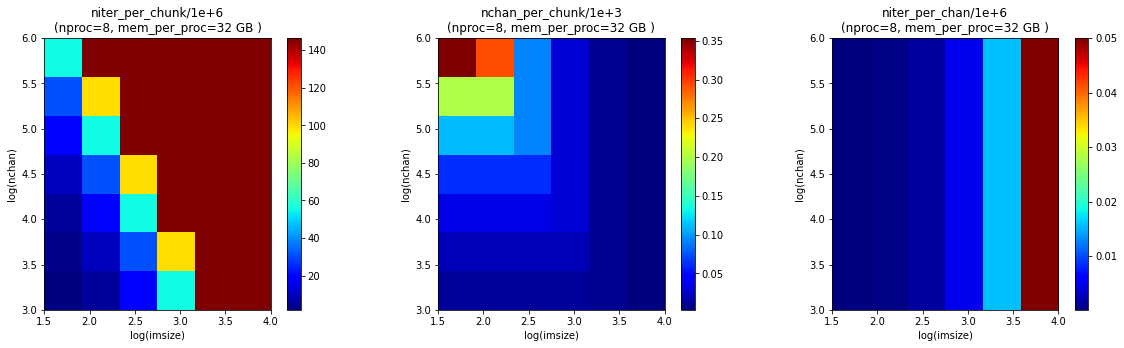

In [4]:
nrecs = calc_minor(nproc=8, mem_per_proc=32)

#### Theory 
The LEFT plot shows the compute load per process (for the optimally chosen chunk size). The cost is lowest at the bottom left and increases towards the top right.  

However, values in the top right triangle are independent of imsize. This is when the problem becomes resource limited, and the extra compute per channel due to imsize is canceled out by forcing the need for fewer channels per chunk, and ultimately needing to loop serially over a larger number of chunks. 

The MIDDLE plot shows nchan_per_chunk computed as per the algorithm above. Smaller imsizes and larger total nchan will naturally result in the most number of channels packed into each chunk, and from that peak, there is a predictable fall off in both dimensions.

The RIGHT plot shows compute load per channel, that simply scales with the number of pixels. 

The LEFT plot is the product of the MIDDLE and RIGHT plots.

#### Measurement
For comparison, below is the empirically derived 'mitigation limit' (from Memo #XX) that ALMA operations uses, when running on compute resources with 8 processes and 256GB ram per machine.


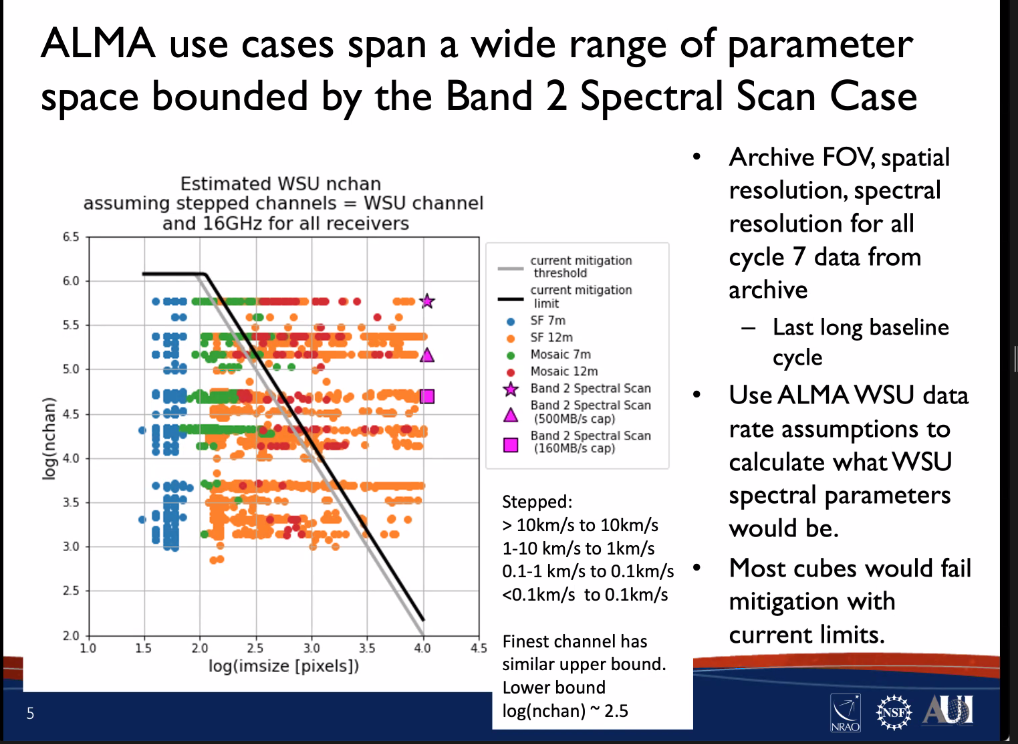

The equivalence between the above theoretical calculation and empirically measured 'mitigation limit' by ALMA for the chosen computing resources, confirms that (at least up to 8 processes) the CASA implementation of parallel cube imaging scales as is theoretically expected from an idealized system.


## Compute resources actually required by ALMA operations
One can now vary the signature of the computing resources, to see what is actually needed, both from the software and from operations.

#### Increased memory per process or node from 32 GB to 256 GB
Assuming CASA's cube write locks limit operations to using only 8 processes, how much can be gained by increasing memory per node ? 

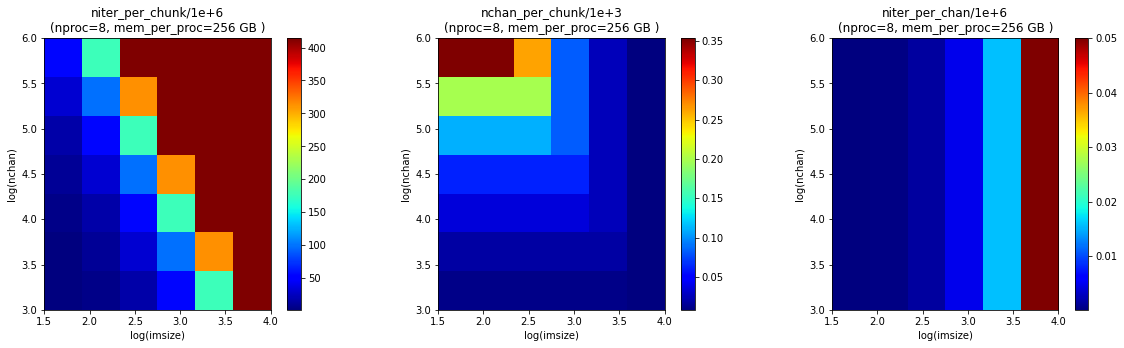

In [5]:
nrecs = calc_minor(nproc=8, mem_per_proc=256)

#### Increased memory per process or node from 32 GB to 1TB

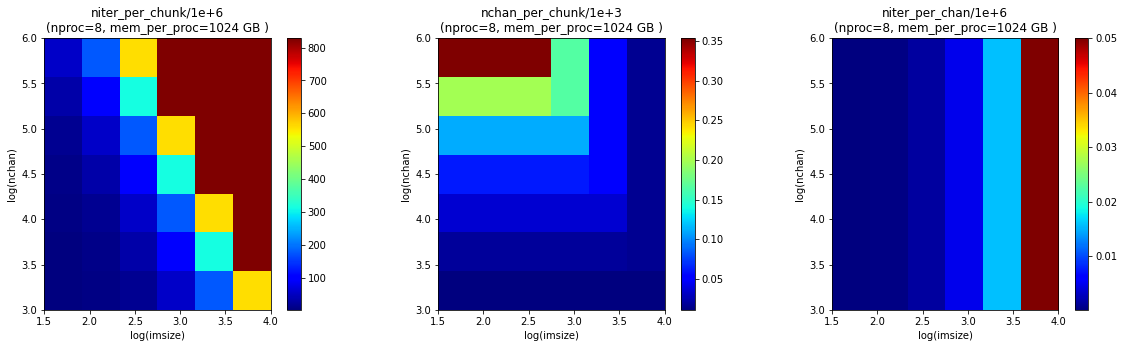

In [6]:
nrecs = calc_minor(nproc=8, mem_per_proc=1024)

Memory increases result in some improvement that might allow more use-cases to proceed un-mitigated. 


#### Increase number of processes or nodes by x 100
This is to test the situation of CASA (or a CNGI implementation) that is not limited to running on 8 processes, but still with a limited amount of memory available to each process.

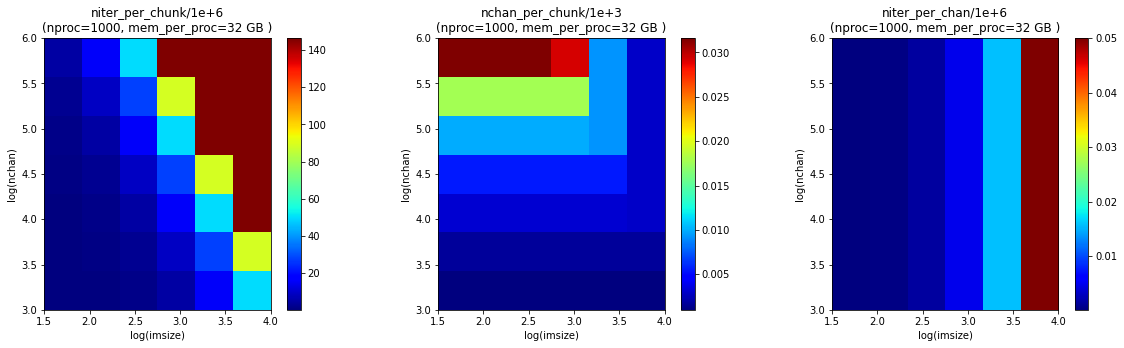

In [7]:
nrecs = calc_minor(nproc=1000, mem_per_proc=32)

#### Increased number of processes or nodes by  x 1000

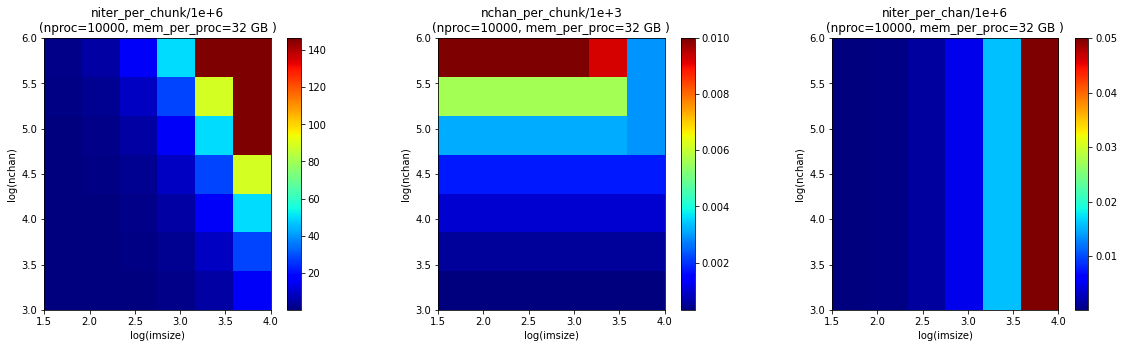

In [8]:
nrecs = calc_minor(nproc=10000, mem_per_proc=32)

The gains from increasing the number of processes are stronger than increasing memory. 

However, neither of the above get very close to the top end of the parameter space, which is where the ALMA-WSU Band 2 Spectral Scan use-case lies. 

#### Increased number of processes or nodes by  x 1000  and memory per process at 256 GB

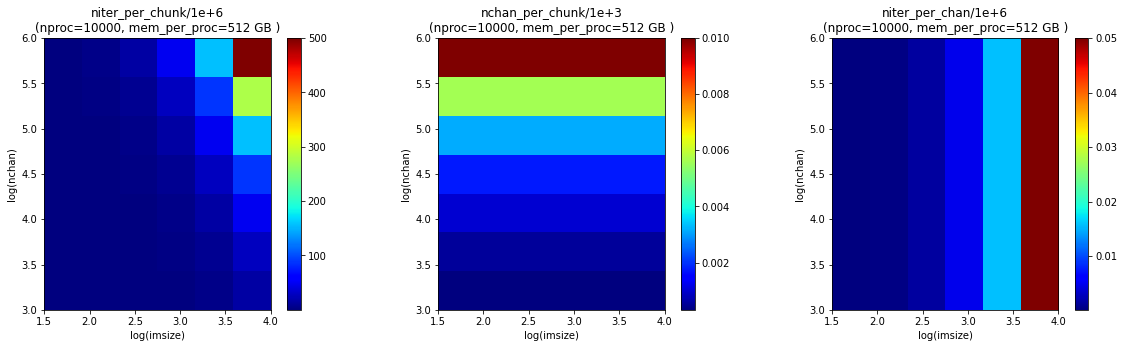

In [9]:
nrecs = calc_minor(nproc=10000, mem_per_proc=512)

This gets closer.

### To Do 
Search/visualize the parameter space of nproc and mem_per_proc to find optimal combinations for the top right of the above plots.  This exercise will deliver compute sizing estimates for 'unmitigated ALMA', and ALMA-WSU. 

(Note that these are very significant resources, even if there is a perfect software implementation)


## Summary

A simple compute model can predict the "mitigation limit" that has been found empirically by analysing ALMA Cycle7 history.  

The assumptions built into the model are
- Perfect scaling relations (and no n_proc limits due to write locks).
- The logic of computing nchan_per_chunk is sound.
- The peak requirement of 10 copies of float-equivalent image grids is justifiable.

### Conclusions
*This is preliminary.* 


### For CASA...
- Up to 8 processes as is used in ALMA operations, the mpicasa Cube parallelization implementation is correctly scaling according to theoretical predictions. Note also the CNGI benchmark tests that include casa6 parallel cube imaging : https://cngi-prototype.readthedocs.io/en/latest/benchmarking.html

- Beyond 8 (or ~16?) processes, it is currently believed that write locks are the limiting factor.
  - CASA Image Cubes would need work to allow parallel writes, but if that is enabled, there is currently no reason to believe that the scaling will not continue beyond 8 processes. 
    - **In other words, if this is indeed the bottleneck, and we can get parallel writes to image cubes, or operate with channel chunks as separate images on disk, CASA can deliver software for un-mitigated ALMA without CNGI.**
  - The CNGI-chosen data formats natively support parallel writes, which have been shown to scale to a few hundred processes.
  

- It would be worth investigating the need to store 10 copies of each float-size image in memory. But, in the calculations above, if the number of copies is reduced from 10 to 5, the "mitigation line" moves up only by 0.5 in log(imsize) and log(nchan). This is equivalent to increasing the mem_per_node by a factor of 2. Therefore, while useful, it is not as significant as increasing n_proc. 
  - Note that the chosen CNGI frameworks (dask) natively handles memory-limited situations with disk I/O as needed (whereas current CASA could crash in parts of the code not already written using constructs such as the LatticeIterators.... ). However, even with robust mechanisms for disk I/O, the runtime costs associated with going to disk cannot be escaped.


### For ALMA operations...
- Moving to higher memory compute nodes, with existing CASA can deliver useful gains with the current code. 
 
- In the theoretical comparison above, performance gains are the greatest when the number of processes is increased. Increasing memory per node also has significant gains, but are far less impactful (on their own) than increasing the number of processes.  Decreasing the algorithms' memory-use per image plane is the least impactful.
 - **Even with perfect software that scales theoretically with n_proc, the number of processes needed for un-mitigated Cycle 7 ALMA cubes are 2 orders of magnitude above what is currently used for operations.** 


